## Basic benchmarks on NNGPR
This notebooks runs NNGPR and the standard Gaussian Process Regressor on a bucnh of toy datasets.
Requires `matplotlib` and `ucimlrepo` packages, next to `scikit-learn` of course.

In [ ]:
import os
import time
import math
import warnings

import joblib
from joblib.parallel import parallel_config
import scipy
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn import metrics
from sklearn import datasets as sk_datasets
from sklearn.exceptions import ConvergenceWarning
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo

from nngpr import NNGPR

##### Config

In [2]:
# Choose datas ets to run. Can choose among 'Elevators', '3droad', 'California_housing', 'Gas_turbine_nox'
dset_names = ['Elevators', '3droad', 'California_housing', 'Gas_turbine_nox']
dset_dims = [1000, 3000, 10000, 20000]  # Each dataset is truncated to the size specified here. If the size is
# larger than the dataset size, the run will be skipped
models_to_run = ['GP', 'NNGPR-32', 'NNGPR-64']
max_gp_dset_size = 20000  # Datasets of bigger size will not be fitted by the plain Gaussian Process Regressor. Change based on you RAM
# size. 20000 was fine on 64GB ram.

test_perc = 0.2  # Define test set fraction
n_restarts_optimizer = 3  # Scikitlearn parameter
results = {}

##### Datasets

In [ ]:
def get_dset(dset_name):
    if dset_name == 'Elevators':  # Taken from GPytorch examples
        data = scipy.io.loadmat('datasets/elevators.mat')['data']
        y = data[:, -1]
        X = data[:, :-1]
        del data
        
    elif dset_name == '3droad':  # Taken from GPytorch examples
        data = scipy.io.loadmat('datasets/3droad.mat')['data']
        X = data[:, :-1]
        y = data[:, -1]
        del data

    elif dset_name == 'California_housing':
        data = sk_datasets.fetch_california_housing()
        X = data['data']
        y = data['target']

    elif dset_name == 'Gas_turbine_nox':
        data = fetch_ucirepo(id=551)
        X = data.data.features.values
        y = X[:, -1]
        X = X[:, :-1]
        
    else:
        raise NotImplementedError(dset_name)
        
    X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    assert(np.all(np.isfinite(X)))
    y = (y - np.mean(y)) / np.std(y)
    assert(np.all(np.isfinite(y)))
    
    train_n = int(math.floor((1-test_perc) * len(X)))
    x_train = X[:train_n, :]
    y_train = y[:train_n]
    
    x_test = X[train_n:, :]
    y_test = y[train_n:]

    return x_train, y_train, x_test, y_test


#### Define fitting functions

In [7]:
def get_kern(x):
    return kernels.ConstantKernel(1e-1) * kernels.RBF(1e-1) + kernels.WhiteKernel(1e-1)

def fit_gp_mdl(x, y, x_test):
    mdl = GaussianProcessRegressor(kernel=get_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer)
    mdl.fit(x, y)
    return mdl.predict(x_test)

def fit_nngpr_mdl(x, y, x_test, num_nn=32):
    # To make a fair comparison, use the same number of jobs as the one used by the openblas, MKL, or similars. Indeed, standard GP performs operations on large matrices
    # which are done in parallel by Blas libraries, while NNGPR works with small matrices which are typically executed sequentially
    n_jobs = int(os.getenv('MKL_NUM_THREADS', os.getenv('OPENBLAS_NUM_THREADS', os.getenv('BLIS_NUM_THREADS', joblib.effective_n_jobs()))))
    mdl = NNGPR(kernel=get_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer, num_nn=num_nn, n_jobs=n_jobs)
    with parallel_config(backend="loky", inner_max_num_threads=1):
        mdl.fit(x, y)
        return mdl.predict(x_test)
    
fit_functions = {
    'GP': fit_gp_mdl,
    'NNGPR': fit_nngpr_mdl,
}

#### Run models

In [ ]:
for dset_name in dset_names:
    if dset_name not in results:
        results[dset_name] = {}
    dset_res = results[dset_name]
    x_train, y_train, x_test, y_test = get_dset(dset_name)
    print(dset_name, x_train.shape)
    
    for n in dset_dims:
        if n not in dset_res:
            dset_res[n] = {}
        this_res = dset_res[n]
        
        for name in models_to_run:
            tag = name
            kwargs = {}
            if (n > x_train.shape[0]) or (name in this_res):
                continue
            if (name == 'GP') and (n > max_gp_dset_size):  # Prevent out of memory
                continue
            if name.startswith('NNGPR'):
                tag = 'NNGPR'
                kwargs['num_nn'] = int(name.split('-')[1])
            print(dset_name, name, n)
            t0 = time.time()
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                pred = fit_functions[tag](x_train[:n], y_train[:n], x_test, **kwargs)
            t = (time.time() - t0) / n_restarts_optimizer
            # metric = metrics.r2_score(y_test, pred)
            this_res[name] = {
                'time': t,
                'pred': pred,
                'y_test': y_test
            }

#### Plot results

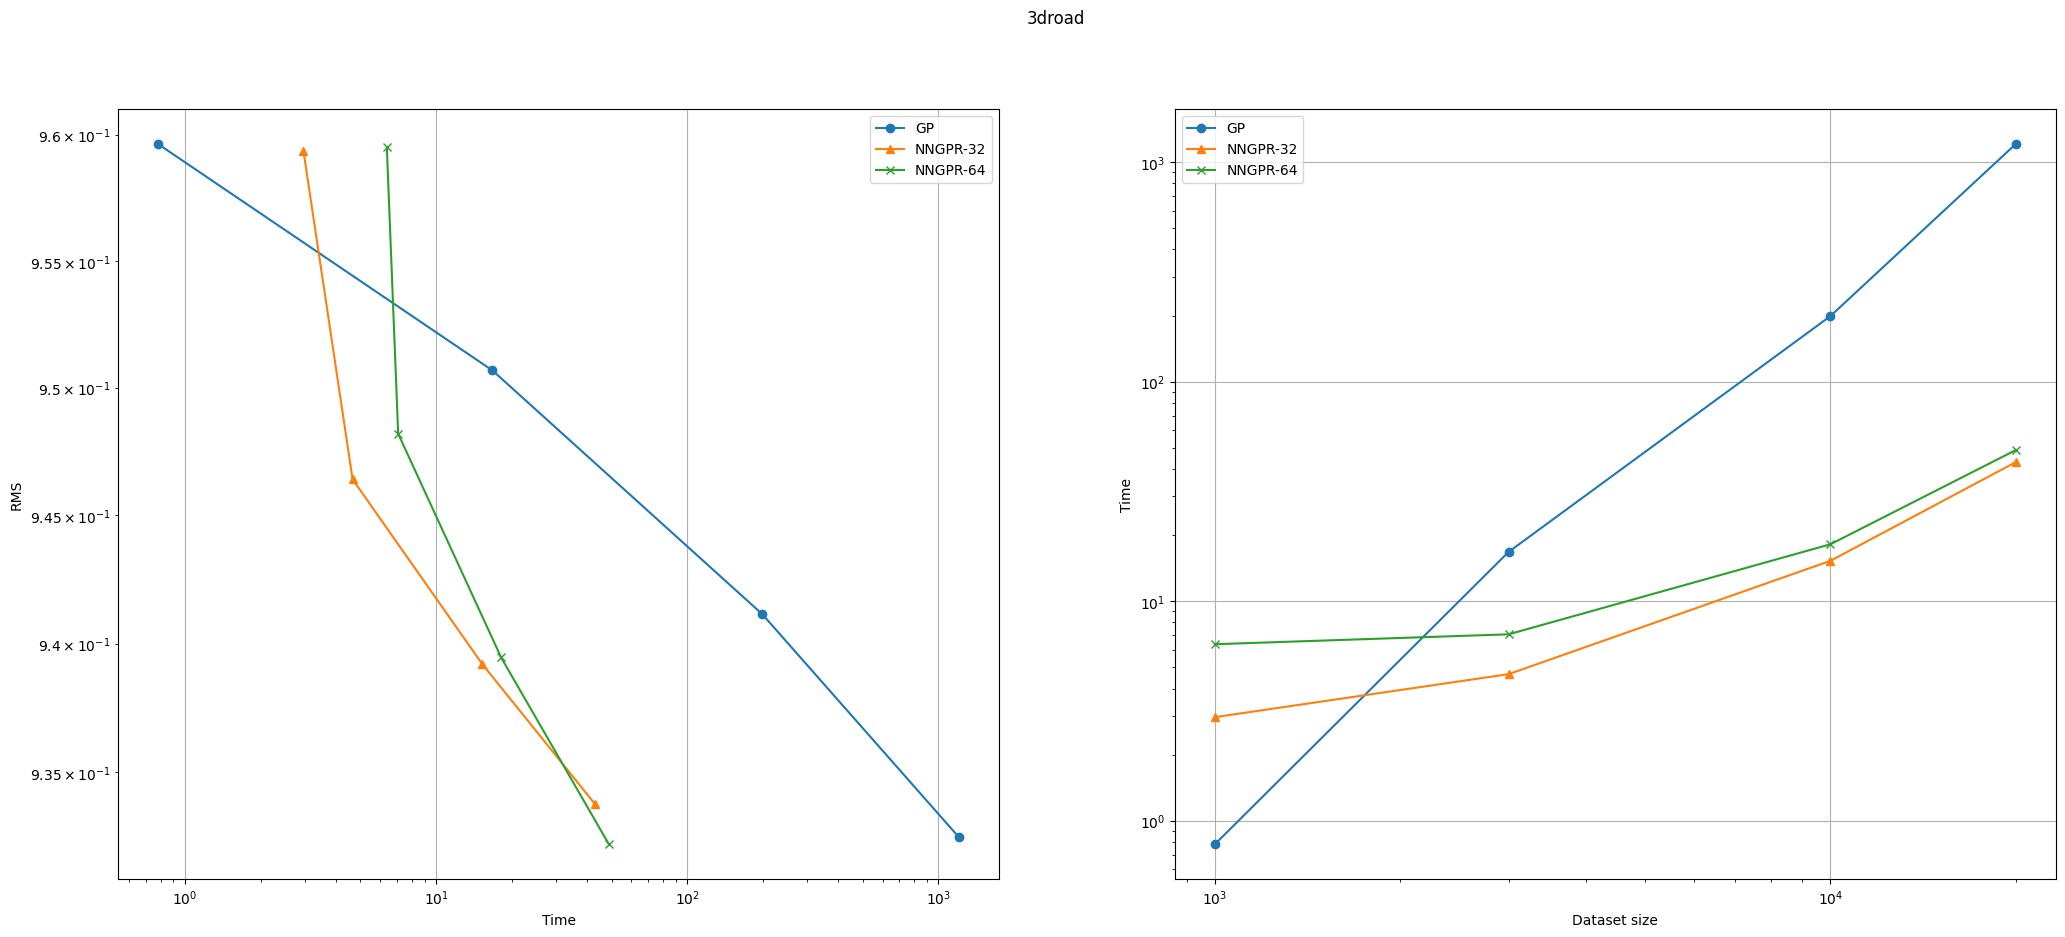

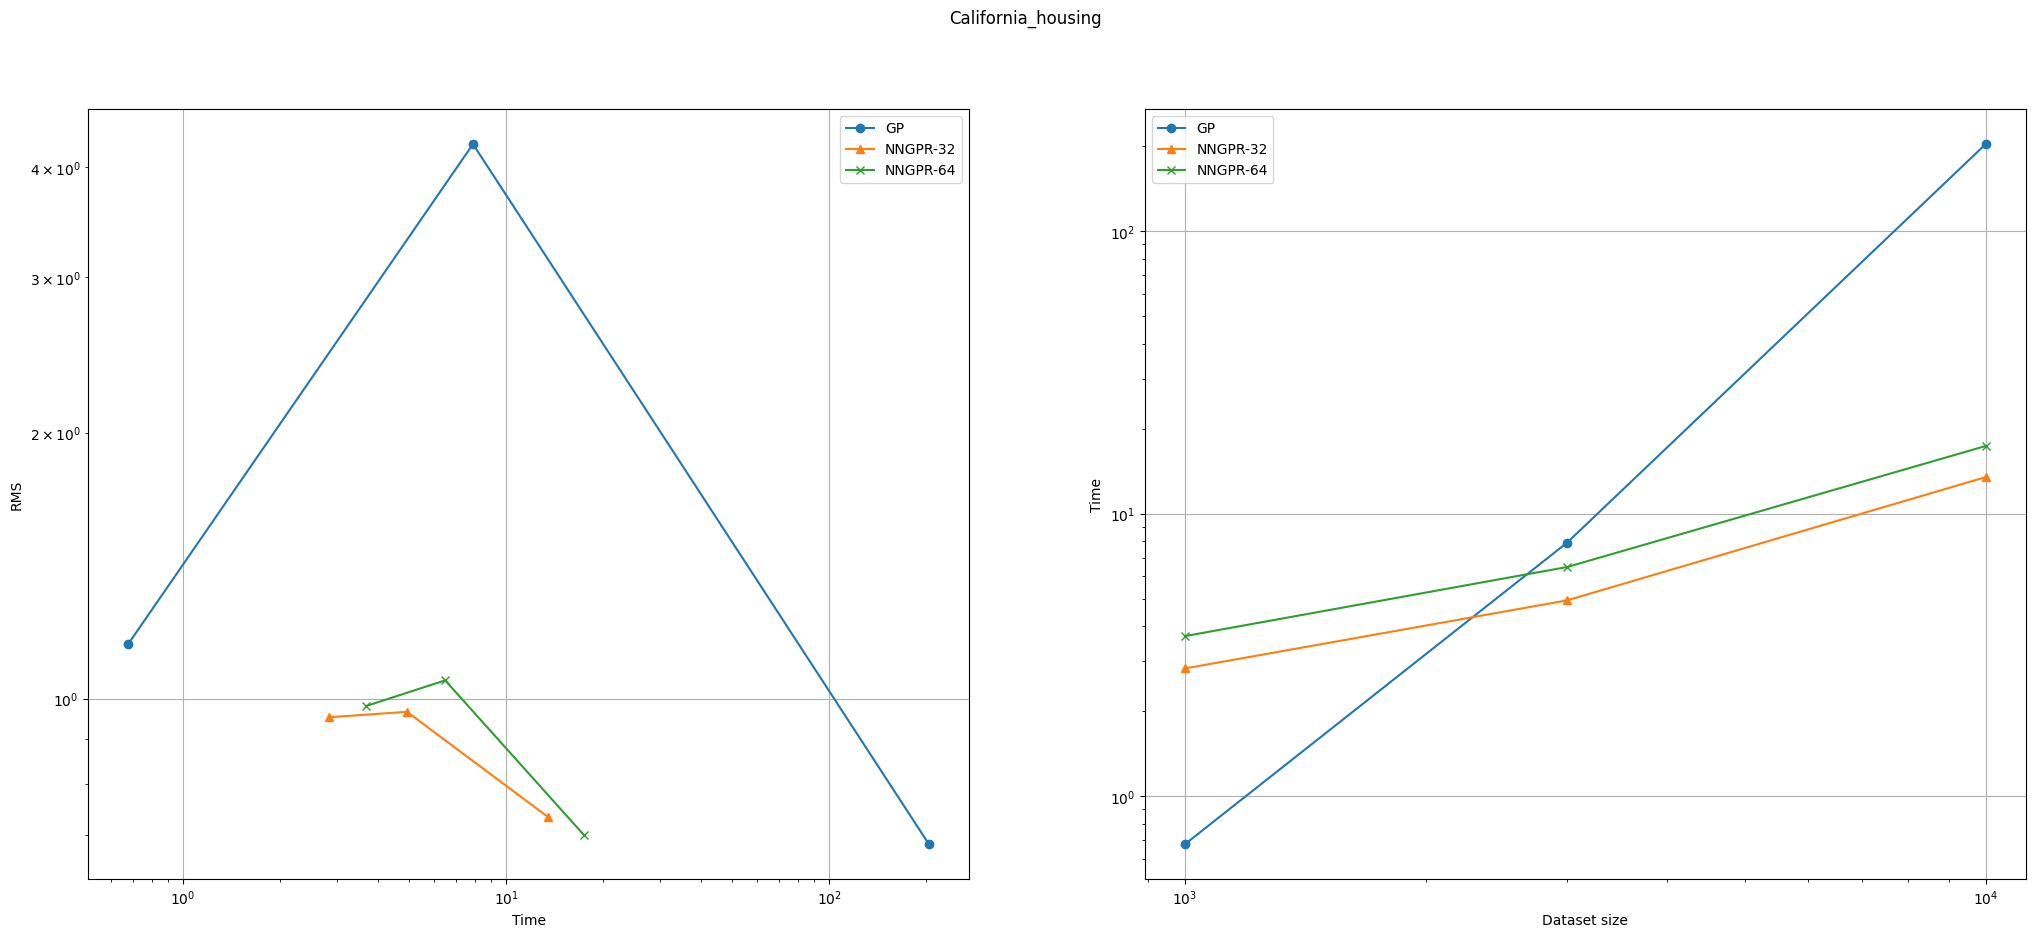

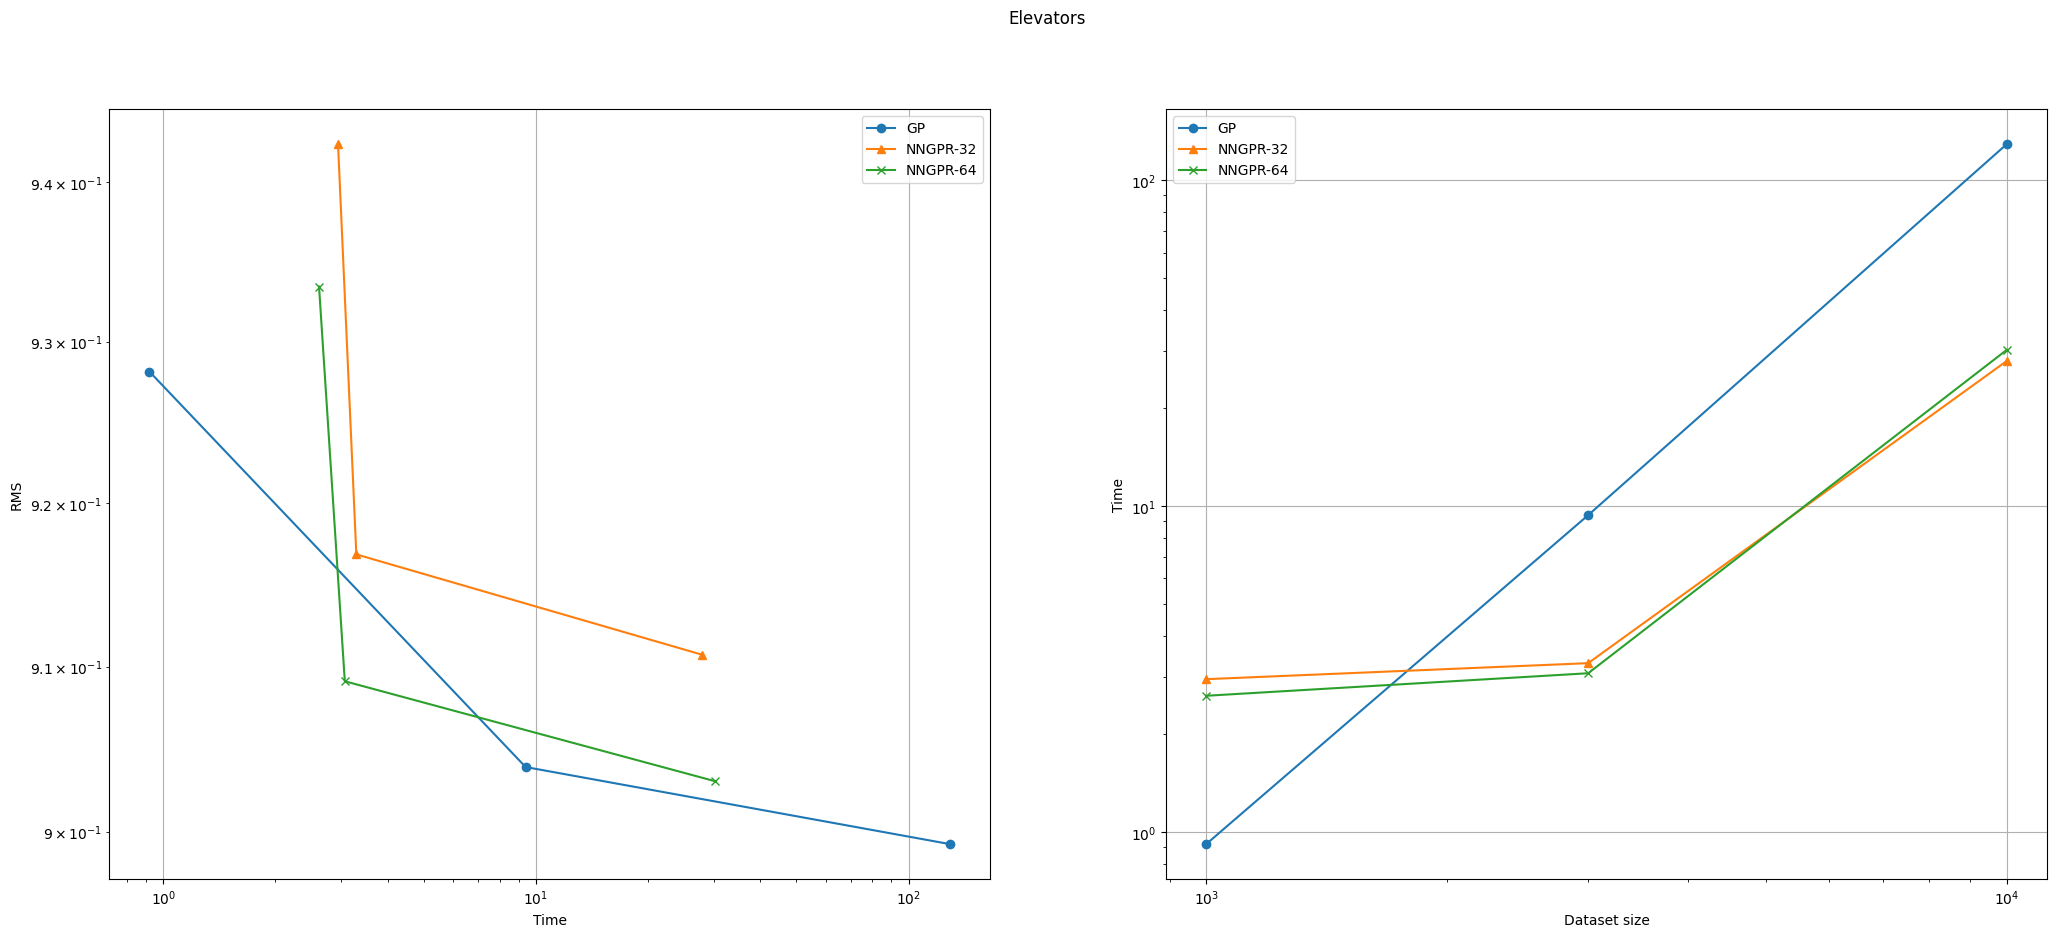

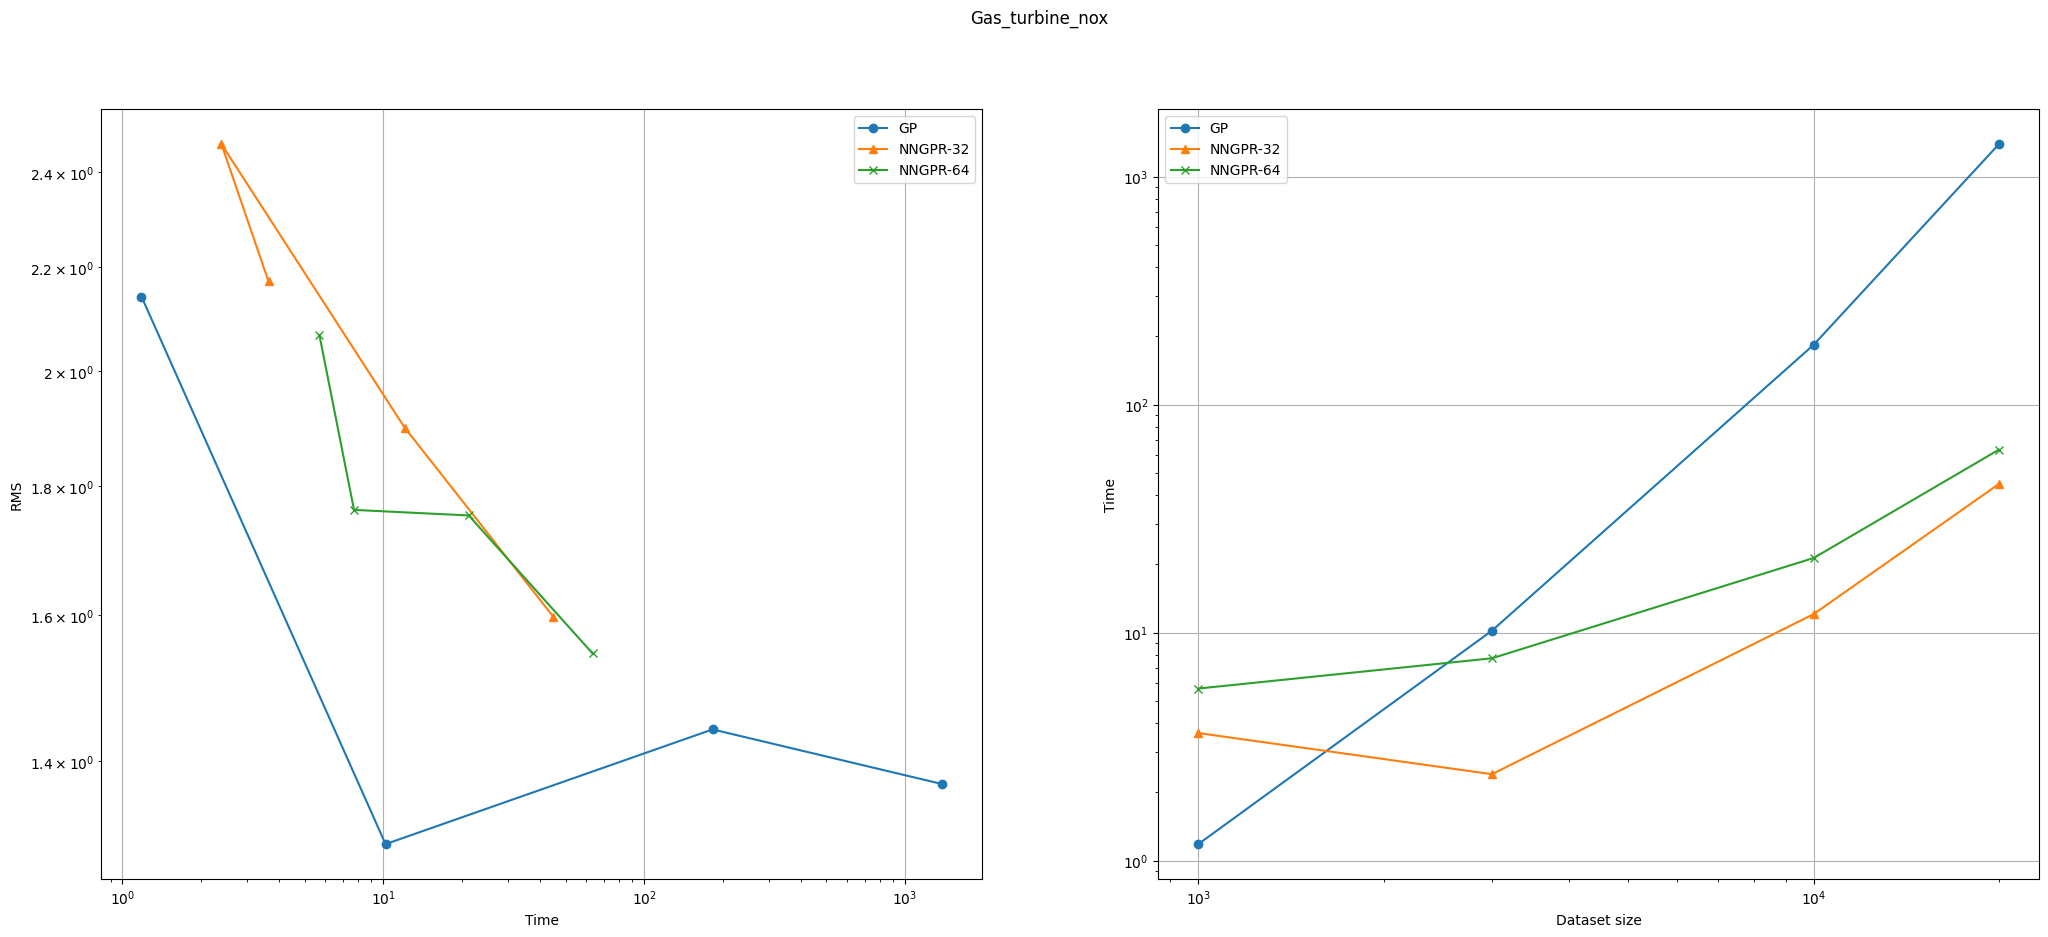

In [13]:
marks = ['o', '^', 'x', '.']

for dset_name in sorted(results):
    dset_results = results[dset_name]
    to_plot = {}
    for n, res in dset_results.items():
        for name, data in res.items():
            if name not in to_plot:
                to_plot[name] = {'time': [], 'metric': [], 'n': []}
            to_plot[name]['time'].append(data['time'])
            to_plot[name]['metric'].append(metrics.root_mean_squared_error(data['y_test'], data['pred']))
            to_plot[name]['n'].append(n)

    for name in list(to_plot.keys()):
        tmp = to_plot[name]
        sorter = np.argsort(tmp['n'])
        to_plot[name] = {'time': np.array(tmp['time'])[sorter], 'metric': np.array(tmp['metric'])[sorter], 'n': np.array(tmp['n'])[sorter]}

    fig, axs = plt.subplots(1,2)
    fig.set_figwidth(25)
    fig.set_figheight(10)
    fig.suptitle(dset_name)

    ax = axs[0]
    ax.grid(True)
    for i, (name, data) in enumerate(to_plot.items()):
        ax.plot(data['time'], data['metric'], '-'+marks[i % len(marks)], label=name)
    ax.set_xlabel('Time')
    ax.set_ylabel('RMS')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()


    ax = axs[1]
    ax.grid(True)
    for i, (name, data) in enumerate(to_plot.items()):
        ax.plot(data['n'], data['time'], '-'+marks[i % len(marks)], label=name)
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('Time')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()